I want to specify the dataset such that:
1. All year information is loaded per tile into a tensor of shape [bands, months, H, W]
2. Handle basic band ransformations
3. Train and test mode are specified
4. Handle tiles with no data

In [3]:
from skimage import io
from joblib import Parallel, delayed
import pandas as pd
import os
import tifffile
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from glob import glob
import logging
import pytorch_lightning as pl
from bioMass.moran_Dataloader import MoranSentinelDataset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings

DIR_DATA = '/home/ubuntu/Thesis/backup_data/bioMass_data/'


class SentinelDataset(Dataset):
    '''Sentinel 1 & 2 dataset.'''

    def __init__(self, is_train, dir_data=DIR_DATA, max_chips=None, transform=None, device='cpu'
                 ):
        
        self.dir_data = dir_data
        self.is_train = is_train
        self.file_metadata = os.path.join(dir_data, 'features_metadata.csv')
        
        self.dataframe = self.parse_dataframe()
        
        self.tile_list = self.dataframe.chip_id.unique()

        if max_chips:
            self.tile_list = self.tile_list[:max_chips]
            
        self.device = device
        # self.transform = transform

        return
    
    def parse_dataframe(self):
        
        dataframe = pd.read_csv(self.file_metadata)
        
        # get the corresponding part of the dataframe
        if self.is_train:
            dataframe = dataframe[dataframe.split=='train']
            dir_features = os.path.join(self.dir_data, 'train_features')
            dir_target = os.path.join(self.dir_data, 'train_agbm')
        else:
            dataframe = dataframe[dataframe.split=='test']
            dir_features = os.path.join(self.dir_data, 'test_features')
            dir_target = os.path.join(self.dir_data, '')
        
        # parse filenames with appropriate directory
        dataframe['filename'] = dataframe.filename.map(lambda x: os.path.join(dir_features, x))
        dataframe['corresponding_agbm'] = dataframe.corresponding_agbm.map(lambda x: os.path.join(dir_target, x))
        
        return dataframe
    
    def _read_tiff_to_tensor(self, filename, check_zeros=True):
        
        # information is in [H, W, C] shape
        X = tifffile.imread(filename).astype(np.float32)
        
        # set bands to first channel
        X = np.moveaxis(X, -1, 0)
        
        assert X.shape[-1]==256
        
        X = torch.tensor(X,
                         dtype=torch.float32,
                         device=self.device,
                         requires_grad=False,
                         )
        
        if check_zeros:
            # check number of zeros in the data across channels
            chk_zeros = X.flatten(1, 2)
            chk_zeros = (chk_zeros==0).sum(dim=1)/chk_zeros.shape[-1]
            
            condition = (chk_zeros>=0.8).sum()>0
            alt_condition = (chk_zeros>0.5).sum()>0
            
            # drop all information whenever more than 80% of data are zeros
            if condition:
                no_info_X = X[chk_zeros>0.8]
                no_info_X = torch.full_like(no_info_X, torch.nan, dtype=torch.float32, requires_grad=False,
                                             device=self.device)

                X[chk_zeros>0.8] = no_info_X

                problematic_file = filename.split('/')[-1]
                warnings.warn(f'{problematic_file} had more than 80% zeros in at least one band')
            
            # replace zero values with some other value when the frequency of zeros is between 50 and 80%?
            # it seems that mostly the CLP band shows this condition, but the information looks useful
            # so maybe leave the CLP for this out?
            elif not condition and alt_condition:
                problematic_file = filename.split('/')[-1]
                warnings.warn(f'{problematic_file} had between 50% and 80% zeros in at least one band')
        
        # Scale all values and replace nans
        X = self._scale_channels(X)
        X = X.nan_to_num_(-1)
        
        return X
    
    def _load_sentinel_tiles(self, chip_id, satellite):
        assert satellite in ['S1', 'S2']

        chip_df = self.dataframe[(self.dataframe.chip_id==chip_id) & (self.dataframe.satellite==satellite)]

        files_list = chip_df.filename.values

        months_list = chip_df.filename.map(lambda x: int(x.split('_')[-1].replace('.tif', ''))).values    

        data = Parallel(len(files_list))(delayed(self._read_tiff_to_tensor)(filename) for filename in files_list)
        data = torch.stack(data)

        return data, months_list
    
    def __getitem__(self, idx):
        chip_id = self.tile_list[idx]
        # Logic: get the available months and fill a tensor with no information for the 12 months. 
        # Then replace the information available in this tensor. No information stays the same.
        
        # S1
        _s1_tile, s1_months_list = self._load_sentinel_tiles(chip_id, 'S1')
        s1_tile = torch.full([12, 4, 256, 256], torch.nan, dtype=torch.float32, requires_grad=False, device=self.device)
        s1_tile[s1_months_list] = _s1_tile
        
        # S2
        _s2_tile, s2_months_list = self._load_sentinel_tiles(chip_id, 'S2')
        s2_tile = torch.full([12, 11, 256, 256], torch.nan, dtype=torch.float32, requires_grad=False, device=self.device)
        s2_tile[s2_months_list] = _s2_tile
        
        if self.is_train:
            target_tile = self._load_agbm_tile(chip_id)
            # 583.80999756 is the 0.9999 quantile of the whole train data
            target_tile = target_tile.clamp(target_tile.min(), 583.80999756).unsqueeze(0)
            # target_tile = torch.log(target_tile+1)
        else:
            target_tile = torch.full([1, 256, 256], torch.nan, dtype=torch.float32, requires_grad=False, device=self.device)

        sample = {'image_s1': s1_tile, 'image_s2': s2_tile,
                  'target': target_tile} 

        # if self.transform:
        #     sample = self.transform(sample)

        return sample
    
    def __len__(self):
        return len(self.tile_list)
    

    def _load_agbm_tile(self, chip_id):
        target_path = self.dataframe[self.dataframe.chip_id==chip_id].corresponding_agbm.unique()
        assert len(target_path)==1
        
        agbm_data = tifffile.imread(target_path[0]).astype(np.float32)
        
        print(agbm_data.shape)
        
        agbm_data = torch.tensor(agbm_data,
                         dtype=torch.float32,
                         device=self.device,
                         requires_grad=False,
                         )
        
        return agbm_data
    
    def _scale_channels(self, x, top_quantile=0.99):
        
        assert len(x.shape)==3
        
        Ms = x.flatten(1, 2).quantile(top_quantile, dim=1, keepdim=True).unsqueeze(-1)
        ms = torch.amin(x, dim=(1, 2), keepdim=True)
        scaled = (x-ms)/(Ms-ms)
        scaled = scaled.clamp(0,1)
        scaled = scaled*600 # make data have the same range as output: (0, 583.80999756)

        return scaled

In [4]:
my_dataset = SentinelDataset(is_train=False)
sample = my_dataset[1]

/tmp/ipykernel_1410413/1121932593.py:102: UserWarning: 01047f47_S2_07.tif had between 50% and 80% zeros in at least one band
/tmp/ipykernel_1410413/1121932593.py:102: UserWarning: 01047f47_S2_10.tif had between 50% and 80% zeros in at least one band


In [5]:
sample['image_s2'].shape, sample['target'].shape

(torch.Size([12, 11, 256, 256]), torch.Size([1, 256, 256]))

# Raise Warnings when not enough information

In [102]:
for data in tqdm(my_dataset):
    _sample, months = data

  0%|          | 0/8689 [00:00<?, ?it/s]

/tmp/ipykernel_1203173/1946095462.py:100: UserWarning: 0003d2eb_S2_07.tif had between 50% and 80% zeros in at least one band
/tmp/ipykernel_1203173/1946095462.py:100: UserWarning: 0003d2eb_S2_10.tif had between 50% and 80% zeros in at least one band
/tmp/ipykernel_1203173/1946095462.py:95: UserWarning: 000aa810_S2_09.tif had more than 80% zeros in at least one band
/tmp/ipykernel_1203173/1946095462.py:95: UserWarning: 001b0634_S2_01.tif had more than 80% zeros in at least one band
/tmp/ipykernel_1203173/1946095462.py:95: UserWarning: 001b0634_S2_02.tif had more than 80% zeros in at least one band
/tmp/ipykernel_1203173/1946095462.py:95: UserWarning: 001b0634_S2_04.tif had more than 80% zeros in at least one band
/tmp/ipykernel_1203173/1946095462.py:95: UserWarning: 001b0634_S2_05.tif had more than 80% zeros in at least one band
/tmp/ipykernel_1203173/1946095462.py:95: UserWarning: 001b0634_S2_06.tif had more than 80% zeros in at least one band
/tmp/ipykernel_1203173/1946095462.py:95: U

In [10]:
chk_zeros = my_dataset._read_tiff_to_tensor('/home/ubuntu/Thesis/backup_data/bioMass_data/train_features/ac963877_S2_10.tif',
                                           check_zeros=False)

# chk_zeros = my_dataset._read_tiff_to_tensor('/home/ubuntu/Thesis/backup_data/bioMass_data/test_features/01047f47_S2_07.tif',
#                                            check_zeros=False)
aux = chk_zeros.flatten(1, 2)
aux = (aux==0).sum(dim=1)/aux.shape[-1]
aux

tensor([0.9650, 0.9650, 0.9650, 0.9650, 0.9650, 0.9650, 0.9650, 0.9650, 0.9650,
        0.9650, 0.9652])

In [11]:
(aux>0.8).sum()>0

tensor(True)

In [12]:
# no_info_tensor = chk_zeros[aux>0.8]
# new_tensor = torch.full_like(no_info_tensor, torch.nan, dtype=torch.float32, requires_grad=False, device='cpu')

# new_tensor.shape

# chk_zeros[aux>0.8] = new_tensor

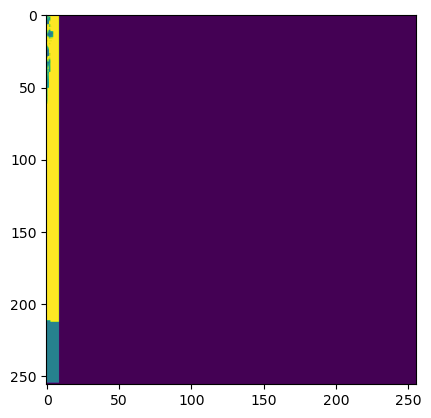

In [14]:
plt.imshow(chk_zeros[0].numpy())